In [0]:
# import basic package
import keras
from PIL import Image
import numpy as np

In [0]:
# import mnist and fashion_mnist dataset
from keras.datasets import mnist,fashion_mnist

# load mnist data
(train_X, train_y), (test_X, test_y) = mnist.load_data()

In [0]:
# load fashion mnist data
(train_fashion_X, train_fashion_y), (test_fashion_X, test_fashion_y) = fashion_mnist.load_data()

In [0]:
# mnist train data type
train_X.dtype

In [125]:
# fashion mnist train data shape
train_fashion_X.dtype

dtype('uint8')

In [126]:
# mnist train data shape
train_X.shape

(60000, 28, 28)

In [130]:
# fashion mnist train data shape
train_fashion_X.shape

(60000, 28, 28)

In [0]:
# view mnist image for no.1
Image.fromarray(train_X[0])

In [128]:
# view fashion mnist image for no.1
Image.fromarray(train_fashion_X[0])

In [0]:
# make mnist data close between 0 and 1
train_X = (train_X[..., None]-127.5)/128

In [0]:
# make fashion mnist data close between 0 and 1
train_fashion_X = (train_fashion_X[..., None]-127.5)/128

In [133]:
# view mnist train data shape
train_X.shape
# train_X[0]

(60000, 28, 28, 1)

In [134]:
# view fashion mnist train data shape
train_fashion_X.shape
# train_fashion_X[0]

(60000, 28, 28, 1)

In [135]:
from IPython.display import display

# define a function to show image
def showX(X, rows=1):
    assert X.shape[0] % rows == 0
    int_X = (X*128+128).clip(0,255).astype('uint8')
    # N*784 -> N*28*28 -> 28*N*28 -> 28 * 28N
    int_X_reshape = int_X.reshape(rows, -1,28,28).swapaxes(1,2).reshape(28*rows,-1)
    display(Image.fromarray(int_X_reshape))
    
# 訓練資料， X 的前 20 筆
showX(train_X[:10])
print(train_y[:10])

[5 0 4 1 9 2 1 3 1 4]


In [0]:
# define number of factor that shrink in the end
NZ = 7

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, Activation, GlobalAveragePooling2D

# define a network : encoder to shape to NZ
netE = Sequential([
    Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='selu', input_shape=(28,28,1)),
    # selu
    Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='selu'),
    Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='selu'),
    Conv2D(filters=NZ, kernel_size=3, strides=1, padding='valid'),
    GlobalAveragePooling2D(),
    Activation('tanh'),
    Reshape([NZ,])
])

In [143]:
# view summary of netE info
netE.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 26, 26, 7)         2023      
_________________________________________________________________
global_average_pooling2d_4 ( (None, 7)                 0         
_________________________________________________________________
activation_4 (Activation)    (None, 7)                 0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 7)                 0         
Total para

In [0]:
# import some basic library
from keras.layers import Conv2DTranspose, Reshape

In [0]:
# define a network generator to reshape factor to image
netG = Sequential([
    Reshape( (1,1,NZ), input_shape=(NZ,)),
    Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='valid', activation='relu'),
    Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='valid', activation='relu'),
    Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
    Conv2DTranspose(filters=1, kernel_size=3, strides=2, padding='same')
    
])

In [146]:
# view netG's summary info
netG.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 1, 1, 7)           0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 3, 3, 32)          2048      
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 7, 7, 32)          9248      
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 14, 14, 32)        9248      
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 20,833
Trainable params: 20,833
Non-trainable params: 0
_________________________________________________________________


In [0]:
from keras.models import Model

# combine two network to whole autoencoder
EG_output = netG(netE.outputs)
netEG = Model(inputs=netE.inputs, outputs=[EG_output])

In [148]:
# view whole network's info
netEG.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12_input (InputLayer) (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 26, 26, 7)         2023      
_________________________________________________________________
global_average_pooling2d_4 ( (None, 7)                 0         
_________________________________________________________________
activation_4 (Activation)    (None, 7)                 0         
__________

In [149]:
import numpy as np

# random new a tensor
showX(netG.predict(np.random.normal( size=(10, NZ))))

In [0]:
# network to comput loss : mse ; optimizer : adam
netEG.compile(loss='mse', optimizer='adam')

In [151]:
# train network
netEG.fit(train_fashion_X, train_fashion_X, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 44s 739us/step - loss: 0.1478
Epoch 2/10
22400/60000 [==========>...................] - ETA: 25s - loss: 0.1009

60000/60000 [==============================] - 40s 662us/step - loss: 0.0975
Epoch 3/10
40928/60000 [===================>..........] - ETA: 12s - loss: 0.0920

60000/60000 [==============================] - 41s 682us/step - loss: 0.0911
Epoch 4/10
50400/60000 [========================>.....] - ETA: 6s - loss: 0.0879

60000/60000 [==============================] - 39s 650us/step - loss: 0.0878
Epoch 5/10
56064/60000 [===========================>..] - ETA: 2s - loss: 0.0856

60000/60000 [==============================] - 39s 642us/step - loss: 0.0857
Epoch 6/10
58656/60000 [============================>.] - ETA: 0s - loss: 0.0840

60000/60000 [==============================] - 38s 625us/step - loss: 0.0840
Epoch 7/10
59968/60000 [============================>.] - ETA: 0s - loss: 0.0828

60000/60000 [==============================] - 38s 630us/step - loss: 0.0828
Epoch 8/10
60000/60000 [==============================] - 37s 624us/step - loss: 0.0817
Epoch 9/10
  320/60000 [..............................] - ETA: 39s - loss: 0.0848

60000/60000 [==============================] - 39s 651us/step - loss: 0.0808
Epoch 10/10
33440/60000 [===============>..............] - ETA: 16s - loss: 0.0808

60000/60000 [==============================] - 37s 623us/step - loss: 0.0800


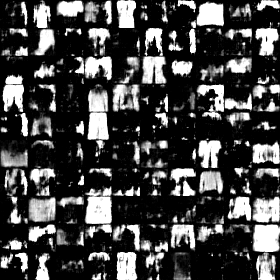

In [152]:
# show result
showX(netG.predict(np.random.normal(size=(100, NZ))), 10)

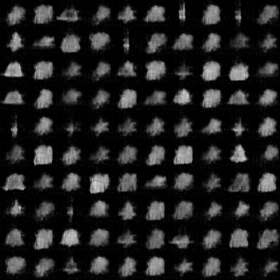

In [153]:
# show result
showX(netEG.predict(train_X[:100]), 10)

In [0]:
# codes = netE.predict(train_X[:1000])
# train_fashion_y
codes = netE.predict(train_fashion_X[train_fashion_y==7])

In [158]:
codes.mean(axis=0)

array([-0.0305008 ,  0.58220035, -0.08546469,  0.19582215, -0.42248678,
        0.58397925, -0.24518585], dtype=float32)

In [159]:
codes

array([[-0.00628214,  0.5693817 , -0.1239658 , ..., -0.49562997,
         0.5776027 , -0.39591563],
       [-0.2303812 ,  0.57308435, -0.30435985, ..., -0.4188403 ,
         0.57842785, -0.23716679],
       [ 0.11055908,  0.61892366, -0.08185839, ..., -0.3191062 ,
         0.68615   , -0.33998632],
       ...,
       [-0.05629585,  0.5917606 , -0.19788468, ..., -0.46201602,
         0.58508265, -0.36669916],
       [ 0.27397263,  0.66813385,  0.10183821, ..., -0.36052805,
         0.5057954 , -0.00401135],
       [-0.06580513,  0.53855485, -0.04533134, ..., -0.37001345,
         0.6734708 , -0.16180563]], dtype=float32)

In [160]:
codes.std(axis=0)

array([0.1659624 , 0.06662271, 0.12518138, 0.13632342, 0.10287028,
       0.0752312 , 0.18893515], dtype=float32)

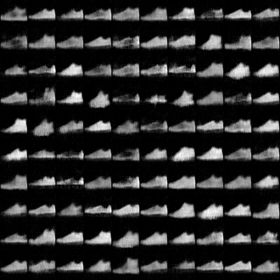

In [161]:
z = np.random.normal(codes.mean(axis=0), scale=codes.std(axis=0), size=(100,NZ))
showX(netG.predict(z), 10)